In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Recurrent Neural Networks (RNN) Tutorial

## Overview
This notebook demonstrates two different approaches to building RNNs in PyTorch:
1. **Method 1**: Manual RNN implementation from scratch
2. **Method 2**: Using PyTorch's built-in `nn.RNN` module

We'll solve two problems:
- **Problem 1**: Name Classification (predicting nationality from names)
- **Problem 2**: Image Classification (CIFAR-10 using RNNs)

---

## Key Concepts

### What is an RNN?
A Recurrent Neural Network processes sequential data by maintaining a "hidden state" that gets updated at each time step. This allows the network to have "memory" of previous inputs.

### RNN Processing Flow
For a sequence like "Albert":
1. Process 'A' → update hidden state
2. Process 'l' with previous hidden state → update hidden state
3. Process 'b' with previous hidden state → update hidden state
4. Continue for 'e', 'r', 't'
5. Use final hidden state for prediction

### Input Shape for RNNs
- **Method 1 (Manual)**: Process one time step at a time `(batch_size, features)`
- **Method 2 (Built-in)**: Process entire sequence `(batch_size, sequence_length, features)`

---

## Method 1: Manual RNN Implementation

**How it works:**
- Manually loop through each character/time step
- Concatenate input with previous hidden state
- Apply linear transformations
- Update hidden state at each step

**Advantages:**
- Full control over the RNN cell
- Easy to understand the mechanics
- Can customize each step

**Disadvantages:**
- Requires manual looping
- Slower for long sequences
- More code to write

---

## Method 2: PyTorch Built-in RNN

**How it works:**
- PyTorch's `nn.RNN` handles all the looping internally
- Pass entire sequence at once
- Automatically returns outputs for all time steps
- We take the last time step for classification

**Advantages:**
- Highly optimized (faster)
- Less code
- Easier to scale

**Disadvantages:**
- Less control over internal mechanics
- Slightly more abstract

---

## Data Representation

### One-Hot Encoding (Text)
Text is converted to one-hot vectors:
- "a" → [1, 0, 0, ..., 0] (58 dimensions)
- Each character gets a unique position set to 1

### Sequence Tensor Shape
For a name like "Albert":
- Shape: `(6, 1, 58)`
  - 6 = sequence length (6 characters)
  - 1 = batch size (processing one name)
  - 58 = vocabulary size (one-hot encoding)

### Image as Sequence (CIFAR-10)
CIFAR-10 images (3×32×32) are treated as sequences:
- Each row becomes a time step
- Shape transformation: `(batch, 3, 32, 32)` → `(batch, 32, 96)`
  - 32 time steps (rows)
  - 96 features (32 pixels × 3 colors)

---

# Problem 1: Classification of Names

In [2]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [3]:
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


In [20]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [21]:
print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'anc' becomes {lineToTensor('anc')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])
The name 'anc' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

# Problem 2: Image Classification

In [7]:
from torchvision import datasets, transforms
# Transform: Convert image to tensor and normalize (0–1 range)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # normalize to mean=0.5, std=0.5
])

# Download MNIST training & test datasets
train_dataset = datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, transform=transform, download=True
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

In [10]:
class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [22]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([2]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 

In [24]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

Using device = cpu
train examples = 17063, validation examples = 3011


<figure>
  <img src="asset/rnn_workflow.png" alt="Rnn Flow" width="300" height="300">
  <figcaption>How data is processed inside of RNN</figcaption>
</figure>

# Method 1: Manual RNN Implementation

## Architecture Explanation

This RNN processes sequences **one time step at a time**:

### Components:
1. **`input_to_hidden`**: Combines current input with previous hidden state
   - Input size: `input_size + hidden_size`
   - Output size: `hidden_size`
   
2. **`input_to_output`**: Produces output predictions
   - Input size: `input_size + hidden_size`
   - Output size: `output_size` (number of classes)
   
3. **`softmax`**: Converts outputs to log probabilities

### Forward Pass:
```python
# For each character in the sequence:
combined = concat(input_char, hidden_state)  # Combine input with memory
hidden_state = linear(combined)              # Update memory
output = linear(combined)                     # Compute output
output = log_softmax(output)                  # Convert to probabilities
```

### Usage Pattern:
```python
hidden = model.initHidden()
for char in sequence:
    output, hidden = model(char, hidden)
# Use final output for prediction
```

**Key Point**: You must manually loop through the sequence!


## Why Combine Input + Hidden State?

The core idea of an RNN is to use **both current information AND past information** to make decisions. Here's the intuition:

### The Concept

When reading a sequence like "Albert":
- At time step 1 ('A'): We have no history, just the letter 'A'
- At time step 2 ('l'): We need to remember we saw 'A' before
- At time step 3 ('b'): We need to remember 'Al' came before
- And so on...

### How Concatenation Achieves This



In [ ]:
combined = torch.cat((input_tensor, hidden_tensor), 1)



This creates a **single vector** containing:
1. **Current input** - What we're seeing NOW (e.g., current character)
2. **Hidden state** - What we've seen BEFORE (memory from previous time steps)

### Visual Example

Let's say:
- `input_size = 58` (one-hot encoded character)
- `hidden_size = 128` (memory size)

At each time step:


In [ ]:
Current character 'l': [0, 0, 1, 0, ..., 0]  (58 dimensions)
                       ↓
              Concatenate with
                       ↓
Previous memory:       [0.3, -0.5, 0.8, ...]  (128 dimensions)
                       ↓
              Results in:
                       ↓
Combined vector:       [0, 0, 1, ..., 0, 0.3, -0.5, 0.8, ...]  (186 dimensions)
                       ↑____________↑  ↑___________________↑
                         input(58)      hidden_state(128)



### Why This Design?

**The linear layer needs BOTH pieces of information** to decide:
1. **What to remember next** (update hidden state)
2. **What to output** (prediction)



In [ ]:
# The network learns to say things like:
# "If I see 'e' AND the previous letters were 'Alb', 
#  then this is probably a name, update memory accordingly"



### Mathematical Perspective



In [ ]:
hidden_new = f(input_current + hidden_previous)



This is the fundamental RNN equation. The concatenation is just how we implement the "+" operation - we stack the vectors and let a linear layer learn how to combine them.

### Alternative: Why Not Add Them?

You might wonder: "Why concatenate instead of adding?"



In [ ]:
# Why not this?
combined = input_tensor + hidden_tensor  # ❌ Won't work!



**Problem**: They have different dimensions! (58 vs 128)

Even if we made them the same size, **concatenation is better** because:
- ✅ Preserves all information from both sources
- ✅ Lets the network learn how much weight to give each
- ✅ More flexible - the network decides how to combine them

### In PyTorch's Built-in RNN

PyTorch's `nn.RNN` does the same thing internally, but you don't see it because it's hidden inside the optimized implementation. It still combines input + hidden state behind the scenes!

---

**Key Takeaway**: Concatenating input with hidden state is how RNNs achieve their "memory" - they always consider both what they're seeing NOW and what they've seen BEFORE to make decisions.

## Code-Level Comparison: Manual vs Built-in RNN

| Aspect | Method 1: Manual RNN | Method 2: Built-in RNN |
|--------|---------------------|------------------------|
| **Class Definition** | `class RNNModel(nn.Module)` | `class RNN(nn.Module)` |
| **Layers Defined** | • `nn.Linear(input+hidden, hidden)`<br>• `nn.Linear(input+hidden, output)`<br>• `nn.LogSoftmax(dim=1)` | • `nn.RNN(input, hidden, layers, batch_first=True)`<br>• `nn.Linear(hidden, output)` |
| **Initialization** | `self.input_to_hidden`<br>`self.input_to_hidden`<br>`self.softmax` | `self.rnn`<br>`self.fc`<br>`self.hidden_size`, `self.num_layers` |
| **Forward Input** | `forward(input_tensor, hidden_tensor)` | `forward(x)` |
| **Hidden State Init** | `initHidden()` returns `torch.zeros(1, hidden_size)` | `h0 = torch.zeros(num_layers, batch_size, hidden_size)` inside forward |
| **Input Shape** | `(1, input_size)` - single time step | `(batch, seq_len, input_size)` - entire sequence |
| **Processing** | ```python<br>combined = cat(input, hidden)<br>hidden = linear(combined)<br>output = linear(combined)<br>output = log_softmax(output)<br>``` | ```python<br>h0 = zeros(...)<br>out, _ = self.rnn(x, h0)<br>out = out[:, -1, :]<br>out = self.fc(out)<br>``` |
| **Output Shape** | `(1, output_size)` | `(batch, output_size)` |
| **Returns** | `output, hidden_state` (tuple) | `output` (single tensor) |
| **Manual Looping** | ✅ **Required** - Must loop externally | ❌ **Not Required** - Handles internally |
| **Usage Example** | ```python<br>hidden = model.initHidden()<br>for i in range(seq_len):<br>    out, hidden = model(x[i], hidden)<br>``` | ```python<br>output = model(sequence)<br>``` |
| **Concatenation** | `torch.cat((input, hidden), 1)` - **Explicit** | Hidden inside `nn.RNN` - **Implicit** |
| **Activation** | `LogSoftmax` (for NLLLoss) | None (for CrossEntropyLoss) |
| **Time Step Output** | Only final output available | All time steps available (`out[:, -1, :]` takes last) |
| **Hidden State Access** | ✅ After each step | ✅ Final state returned (ignored with `_`) |
| **Flexibility** | Can customize each step | Standard RNN behavior only |
| **Code Lines** | ~18 lines | ~16 lines |
| **Memory Efficient** | Process one at a time | Batch processing |
| **GPU Optimization** | Standard operations | Highly optimized CUDA kernels |

---

### Key Architectural Differences

#### **1. Layer Construction**

**Method 1 (Manual):**
```python
self.input_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)
self.input_to_output = nn.Linear(input_size + hidden_size, output_size)
self.softmax = nn.LogSoftmax(dim=1)
```

**Method 2 (Built-in):**
```python
self.rnn = nn.RNN(input_size, hidden_size, num_rnn_layers, batch_first=True)
self.fc = nn.Linear(hidden_size, output_size)
```

#### **2. Forward Pass Logic**

**Method 1 (Manual):**
```python
def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)  # Manually combine
    hidden_state = self.input_to_hidden(combined)           # Update hidden
    output = self.input_to_output(combined)                 # Compute output
    output = self.softmax(output)                           # Apply softmax
    return output, hidden_state                             # Return both
```

**Method 2 (Built-in):**
```python
def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    out, _ = self.rnn(x, h0)        # RNN handles all time steps
    out = out[:, -1, :]             # Extract last time step
    out = self.fc(out)              # Classify
    return out                      # Return only output
```

#### **3. Training Loop Differences**

**Method 1 Usage:**
```python
for i in batch:
    hidden = rnn.initHidden()                    # Initialize hidden
    for j in range(text_tensor.size()[0]):       # Loop through sequence
        output, hidden = rnn(text_tensor[j], hidden)  # One step at a time
    loss = criterion(output, label)              # Use final output
```

**Method 2 Usage:**
```python
for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.reshape(-1, seq_len, input_size)  # Reshape to sequence
    outputs = rnn(inputs)                              # Process entire batch
    loss = criterion(outputs, labels)                  # Compute loss
```

---

### Performance Comparison

| Metric | Method 1 | Method 2 |
|--------|----------|----------|
| **Speed** | ~10-50x slower | Baseline (fastest) |
| **Memory** | Lower (one step) | Higher (full sequence) |
| **Batch Size** | Effectively 1 | Full batch (64, 128, etc.) |
| **Parallelization** | Limited | Excellent |

---

### When to Use Each

**Use Method 1 (Manual) when:**
- 🎓 Learning RNN internals
- 🔧 Need custom RNN cell behavior
- 📊 Want step-by-step inspection
- 🧪 Prototyping new architectures

**Use Method 2 (Built-in) when:**
- 🚀 Production code
- ⚡ Speed matters
- 📦 Standard RNN behavior is sufficient
- 💼 Working with large datasets

In [33]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.input_to_hidden=nn.Linear(input_size + hidden_size, hidden_size)
        self.input_to_output=nn.Linear(input_size + hidden_size, output_size)
        self.softmax=nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined=torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden_state=self.input_to_hidden(combined)
        output=self.input_to_output(combined)
        output=self.softmax(output)
        return output, hidden_state

    def initHidden(self):
        return torch.zeros(1, self.hidden_size) 

# Method 2: PyTorch Built-in RNN

## Architecture Explanation

This RNN uses PyTorch's optimized `nn.RNN` module that processes **entire sequences at once**:

### Components:
1. **`self.rnn`**: PyTorch's RNN layer
   - `input_size`: Features per time step
   - `hidden_size`: Size of hidden state
   - `num_layers`: Number of stacked RNN layers
   - `batch_first=True`: Input shape is `(batch, sequence, features)`
   
2. **`self.fc`**: Fully connected layer for classification
   - Input size: `hidden_size`
   - Output size: `output_size` (number of classes)

### Forward Pass:
```python
# Initialize hidden state
h0 = zeros(num_layers, batch_size, hidden_size)

# Process entire sequence at once
out, hidden = self.rnn(x, h0)
# out shape: (batch, sequence_length, hidden_size)

# Take only the last time step
out = out[:, -1, :]  # Shape: (batch, hidden_size)

# Classify
out = self.fc(out)   # Shape: (batch, num_classes)
```

### Key Differences from Method 1:
- ✅ No manual looping required
- ✅ Much faster (optimized CUDA kernels)
- ✅ Returns outputs for ALL time steps
- ✅ We extract the last time step `out[:, -1, :]` for classification

### Usage Pattern:
```python
# Just pass the entire sequence!
output = model(sequence)  # sequence shape: (batch, seq_len, features)
```

**Why take the last time step?**
The last time step's output contains information from the entire sequence (all previous time steps), making it ideal for classification tasks.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_rnn_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_rnn_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_rnn_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Initial hidden state
        out, _ = self.rnn(x, h0)  
        # out shape: (batch_size, sequence_length, hidden_size)
        # We only need the output from the last time step
        out = out[:, -1, :]  # Take the last time step: (batch_size, hidden_size)
        out = self.fc(out)  # (batch_size, output_size)
        return out

In [23]:
# CIFAR-10 images are 3x32x32 (3 color channels, 32x32 pixels)
# We'll treat each row as a sequence: 32 rows, each with 32*3=96 features
input_size = 32 * 3  # 96 features per time step (32 pixels x 3 color channels)
sequence_length = 32  # 32 rows (time steps)
num_rnn_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.001
batch_size = 64
n_epochs = 5
rnn = RNN(input_size, hidden_size, num_rnn_layers, num_classes)
print(rnn)

RNN(
  (rnn): RNN(96, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(rnn.parameters(), lr=learning_rate)

## Why Permute and Reshape for Images?

### The Problem: Image Format vs Sequence Format

**CIFAR-10 images come in this shape:**
- `(batch, channels, height, width)` = `(64, 3, 32, 32)`
- This is the **standard PyTorch image format**
- Channels first: RGB values are separated

**But RNN expects sequences in this shape:**
- `(batch, sequence_length, features)` = `(64, 32, 96)`
- Each time step should have ALL features for that step

### Visual Explanation

**Original Image Shape: (3, 32, 32)**
```
Channel dimension:
├─ Red channel:    32×32 pixels
├─ Green channel:  32×32 pixels  
└─ Blue channel:   32×32 pixels
```

**We want to treat each ROW as a time step:**
- Row 1: All RGB values from the first row (32 pixels × 3 colors = 96 features)
- Row 2: All RGB values from the second row (96 features)
- Row 3: All RGB values from the third row (96 features)
- ... up to Row 32

### Why Two Steps?

#### Step 1: **Permute** `(batch, 3, 32, 32)` → `(batch, 32, 32, 3)`
```python
inputs = inputs.permute(0, 2, 3, 1)
```
- **What it does**: Moves channels from dimension 1 to dimension 3
- **Why**: We need RGB values together for each pixel
- **Result**: Now each pixel has its 3 color values grouped together

#### Step 2: **Reshape** `(batch, 32, 32, 3)` → `(batch, 32, 96)`
```python
inputs = inputs.reshape(-1, sequence_length, input_size)
```
- **What it does**: Flattens each row into a single feature vector
- **Why**: RNN needs `(batch, seq_len, features)` format
- **Result**: 32 rows (time steps), each with 96 features (32 pixels × 3 colors)

### Comparison with Text Sequences

**Your earlier image (text sequences):**
```python
# Text already comes as sequences!
text_tensor = lineToTensor("Albert")  # Shape: (6, 1, 58)
# 6 time steps (characters), already in sequence format
# NO permute/reshape needed! ✓
```

**CIFAR-10 images (need conversion):**
```python
# Images come as (batch, C, H, W), NOT as sequences
images = load_cifar()  # Shape: (64, 3, 32, 32)
# Must convert to sequence format
images = images.permute(0, 2, 3, 1)  # ← Reorder dimensions
images = images.reshape(-1, 32, 96)   # ← Flatten into sequences
# NOW it's (64, 32, 96) - ready for RNN! ✓
```

### Key Difference

| Data Type | Original Format | Needs Conversion? | Why? |
|-----------|----------------|-------------------|------|
| **Text** | Already sequential (character-by-character) | ❌ No | Text is naturally a sequence |
| **Images** | Grid format (height × width × channels) | ✅ Yes | Images are 2D grids, not sequences |

### What if we skip permute?

```python
# ❌ WRONG: Skip permute, just reshape
images.reshape(-1, 32, 96)  # (64, 3, 32, 32) → (64, 32, 96)
# Problem: This would group pixels incorrectly!
# Row 1 would have: all reds from first 10 pixels, then some greens...
# The RGB values wouldn't be together!
```

**Correct way with permute:**
```python
# ✓ RIGHT: Permute then reshape  
images.permute(0, 2, 3, 1).reshape(-1, 32, 96)
# Row 1: [R₁, G₁, B₁, R₂, G₂, B₂, ..., R₃₂, G₃₂, B₃₂]
# Each pixel's RGB values stay together!
```

In [27]:
# Demo: Why we need permute + reshape
print("=" * 70)
print("Understanding Image to Sequence Conversion")
print("=" * 70)

# Create a small example image (1 batch, 3 channels, 4x4 pixels)
example_image = torch.randn(1, 3, 4, 4)
print(f"\n1. Original image shape: {example_image.shape}")
print(f"   Format: (batch, channels, height, width)")
print(f"   This is how PyTorch stores images: RGB separated")

# Step 1: Permute
permuted = example_image.permute(0, 2, 3, 1)
print(f"\n2. After permute(0, 2, 3, 1): {permuted.shape}")
print(f"   Format: (batch, height, width, channels)")
print(f"   Now RGB values are together for each pixel")

# Step 2: Reshape
sequence = permuted.reshape(1, 4, 12)  # 4 rows, 12 features (4 pixels × 3 colors)
print(f"\n3. After reshape(1, 4, 12): {sequence.shape}")
print(f"   Format: (batch, sequence_length, features)")
print(f"   Each row is now a time step with all pixel RGB values")

print(f"\n{'=' * 70}")
print("For CIFAR-10:")
print(f"  (64, 3, 32, 32) → permute → (64, 32, 32, 3) → reshape → (64, 32, 96)")
print(f"  64 images, 32 time steps, 96 features per step")
print("=" * 70)

Understanding Image to Sequence Conversion

1. Original image shape: torch.Size([1, 3, 4, 4])
   Format: (batch, channels, height, width)
   This is how PyTorch stores images: RGB separated

2. After permute(0, 2, 3, 1): torch.Size([1, 4, 4, 3])
   Format: (batch, height, width, channels)
   Now RGB values are together for each pixel

3. After reshape(1, 4, 12): torch.Size([1, 4, 12])
   Format: (batch, sequence_length, features)
   Each row is now a time step with all pixel RGB values

For CIFAR-10:
  (64, 3, 32, 32) → permute → (64, 32, 32, 3) → reshape → (64, 32, 96)
  64 images, 32 time steps, 96 features per step


## Direct Comparison: Text vs Images

### Text Sequences (Your earlier example) ✅ No preprocessing needed

```python
# Text is already sequential!
name = "Albert"
text_tensor = lineToTensor(name)
print(text_tensor.shape)  # (6, 1, 58)
                          # ↑  ↑  ↑
                          # |  |  └─ Features (58 one-hot characters)
                          # |  └──── Batch size (1 name)
                          # └─────── Sequence length (6 characters)

# Feed directly to RNN - it's already in sequence format!
for i in range(text_tensor.size()[0]):
    output, hidden = rnn(text_tensor[i], hidden)
```

**Why no preprocessing?** Text is inherently sequential. Each character is already a time step.

---

### Image Sequences (CIFAR-10) ❌ Needs preprocessing

```python
# Images come in grid format, NOT sequential!
images, labels = next(iter(train_loader))
print(images.shape)  # (64, 3, 32, 32)
                     # ↑   ↑  ↑   ↑
                     # |   |  |   └─ Width (32 pixels)
                     # |   |  └───── Height (32 pixels)
                     # |   └──────── Channels (R, G, B)
                     # └──────────── Batch size (64 images)

# ❌ Can't feed directly to RNN - wrong format!
# ✅ Must convert to sequence format first:

# Step 1: Move channels to last dimension
images = images.permute(0, 2, 3, 1)  # (64, 32, 32, 3)

# Step 2: Flatten each row into features
images = images.reshape(-1, 32, 96)  # (64, 32, 96)
                                     # ↑   ↑   ↑
                                     # |   |   └─ Features (32 pixels × 3 colors)
                                     # |   └───── Sequence length (32 rows)
                                     # └─────────Batch size (64 images)

# NOW it's in sequence format - ready for RNN!
output = rnn(images)
```

**Why preprocessing?** Images are 2D grids, not sequences. We artificially treat rows as time steps.

---

### Summary

| Aspect | Text | Images |
|--------|------|--------|
| **Natural format** | Sequential (character-by-character) | Grid (2D array) |
| **As received** | Already sequence-like | Grid format `(B, C, H, W)` |
| **Preprocessing** | None needed | `permute()` + `reshape()` |
| **Why different?** | Text IS a sequence | Images BECOME sequences |
| **What's a time step?** | One character | One row of pixels |

In [24]:
for epoch in range(n_epochs):  # loop over the dataset multiple times
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # CIFAR-10: (batch, 3, 32, 32) -> (batch, 32, 96)
        # Reshape: batch_size x 3 x 32 x 32 -> batch_size x 32 x 96
        inputs = inputs.permute(0, 2, 3, 1)  # (batch, 32, 32, 3)
        inputs = inputs.reshape(-1, sequence_length, input_size)  # (batch, 32, 96)
        
        # Forward pass
        outputs = rnn(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')
    print(f'Epoch [{epoch + 1}/{n_epochs}] completed, Loss: {loss.item():.4f}')
print('Finished Training')

Epoch [1/5], Step [0/782], Loss: 2.3007
Epoch [1/5], Step [100/782], Loss: 2.3150
Epoch [1/5], Step [100/782], Loss: 2.3150
Epoch [1/5], Step [200/782], Loss: 2.2998
Epoch [1/5], Step [200/782], Loss: 2.2998
Epoch [1/5], Step [300/782], Loss: 2.2700
Epoch [1/5], Step [300/782], Loss: 2.2700
Epoch [1/5], Step [400/782], Loss: 2.2978
Epoch [1/5], Step [400/782], Loss: 2.2978
Epoch [1/5], Step [500/782], Loss: 2.3258
Epoch [1/5], Step [500/782], Loss: 2.3258
Epoch [1/5], Step [600/782], Loss: 2.2951
Epoch [1/5], Step [600/782], Loss: 2.2951
Epoch [1/5], Step [700/782], Loss: 2.3128
Epoch [1/5], Step [700/782], Loss: 2.3128
Epoch [1/5] completed, Loss: 2.2672
Epoch [2/5], Step [0/782], Loss: 2.3111
Epoch [1/5] completed, Loss: 2.2672
Epoch [2/5], Step [0/782], Loss: 2.3111
Epoch [2/5], Step [100/782], Loss: 2.3248
Epoch [2/5], Step [100/782], Loss: 2.3248
Epoch [2/5], Step [200/782], Loss: 2.2859
Epoch [2/5], Step [200/782], Loss: 2.2859
Epoch [2/5], Step [300/782], Loss: 2.3401
Epoch [2/5

In [26]:
rnn.eval()

correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Reshape the same way as in training
        X_batch = X_batch.permute(0, 2, 3, 1)  # (batch, 32, 32, 3)
        X_batch = X_batch.reshape(-1, sequence_length, input_size)  # (batch, 32, 96)
        
        outputs = rnn(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 10.09%


# Method 1 Train and evaluate

In [34]:
n_hidden = 128 # start small
model = RNNModel(n_letters, n_hidden, len(alldata.labels_uniq)).to(device)
print(model)

RNNModel(
  (input_to_hidden): Linear(in_features=186, out_features=128, bias=True)
  (input_to_output): Linear(in_features=186, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [36]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

hidden_state = model.initHidden()
input = lineToTensor('Albert')

# Loop through each character in the sequence
for i in range(input.size()[0]):
    output, hidden_state = model(input[i], hidden_state)
    
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.8762, -2.9271, -2.8852, -2.9765, -2.8594, -2.8838, -2.7746, -2.8978,
         -2.9350, -2.9942, -2.8139, -2.9554, -2.9709, -2.8508, -2.8357, -2.8770,
         -2.9392, -2.8074]], grad_fn=<LogSoftmaxBackward0>)
('Russian', 6)


In [44]:
n_epoch = 10
n_batch_size = 64
report_every = 50
learning_rate = 0.2
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [45]:
import random
import numpy as np

def train(rnn, training_data):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    model.train()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        model.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                
                # Initialize hidden state for this example
                hidden = rnn.initHidden()
                
                # Loop through each character in the sequence
                for j in range(text_tensor.size()[0]):
                    output, hidden = rnn(text_tensor[j], hidden)
                
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [46]:
start = time.time()
all_losses = train(model, train_set)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
training took 578.5927290916443s
training took 578.5927290916443s


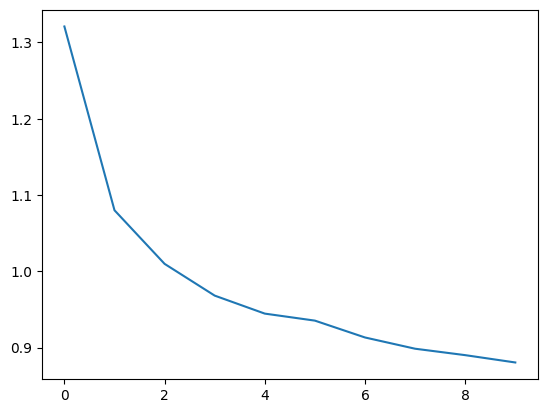

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# Summary & Key Takeaways

## Method Comparison

| Aspect | Method 1 (Manual) | Method 2 (Built-in) |
|--------|-------------------|---------------------|
| **Code Complexity** | More complex (manual loops) | Simpler (automatic) |
| **Speed** | Slower | Faster (optimized) |
| **Control** | Full control over each step | Less control |
| **Input Shape** | `(batch, features)` per step | `(batch, seq_len, features)` |
| **Best For** | Learning, custom RNN cells | Production, standard RNNs |

---

## Important Concepts Covered

### 1. **Sequential Processing**
RNNs process data one step at a time, maintaining a hidden state that acts as "memory"

### 2. **Hidden State**
- Carries information from previous time steps
- Gets updated at each step
- Final hidden state contains information about the entire sequence

### 3. **One-Hot Encoding**
- Converts categorical data (characters) into numerical vectors
- Each character gets a unique position in a vector
- Essential for neural network input

### 4. **Tensor Shapes Matter!**
- **Method 1**: `torch.zeros(seq_len, 1, features)` - process one at a time
- **Method 2**: `(batch, seq_len, features)` - process entire batch
- Always verify tensor shapes match model expectations

### 5. **Image as Sequence**
- Images can be treated as sequences (rows as time steps)
- CIFAR-10: `(3, 32, 32)` → `(32, 96)` where 32 = rows, 96 = pixels×channels
- Reshape: `permute(0,2,3,1)` then `reshape(-1, seq_len, features)`

---

## Common Pitfalls & Solutions

### ❌ **Problem**: Shape mismatch errors
**Solution**: Always check tensor shapes with `.shape` before passing to model

### ❌ **Problem**: Forgetting to loop in Method 1
**Solution**: Must manually loop through sequence for manual RNN

### ❌ **Problem**: Using all outputs instead of last one (Method 2)
**Solution**: Use `out[:, -1, :]` to get last time step

### ❌ **Problem**: Forgetting `.to(device)` when using GPU
**Solution**: Always move model and data to same device

### ❌ **Problem**: Not reshaping test data the same as training data
**Solution**: Apply identical preprocessing to both train and test data

---

## When to Use RNNs?

✅ **Good for:**
- Text classification
- Sequence prediction
- Time series analysis
- Variable-length inputs

❌ **Consider alternatives for:**
- Very long sequences (use LSTM/GRU instead)
- Parallel processing (use Transformers)
- Image classification (CNNs are better)

---

## Next Steps

1. **Try LSTM/GRU**: Better at capturing long-term dependencies
2. **Experiment with bidirectional RNNs**: Process sequences forward and backward
3. **Stack multiple RNN layers**: Increase model capacity
4. **Try different optimizers**: Adam vs SGD vs RMSprop
5. **Tune hyperparameters**: hidden_size, learning_rate, num_layers
